# Estimating GDP figures based on nighttime satellite data

### Topic introduction
Satellite images of countries during the night can be used to predict GDP figures for countries and regions. This notebook explains how to do so using satellite images which were collected and cleaned by the [National Oceanic and Atmospheric Administration of the United States (NOAA)](noaa.gov).

After loading and preparing the relevant data this notebook specifically explores three exemplatory use cases:
1. Using satellite images to estimate the GDP of countries with unpublished figures (e.g. North Korea)
2. Estimating the GDP of a region
3. Estimating the next GDP of a country given the previous GDP figures and the light data for the year in question


### Structure of this notebook:
0. *Packages*
1. *Data* Preparation
2. Making *predictions* based on regressions
    1. Predicting the GDP of a country without a published GDP
    2. Predicting the GDP of a specific region
    3. Predicting the GDP for a country for a future year based on the light data
3. (Bonus) Building a multiple regression

### Data used in this notebook: 
The satellite data was collected and cleaned by the NOAA in the course of the Defense Meteorological Satellite Program (DMSP) using the Operational Linescan System (OLS).The files are cloud-free using all the available data for calendar years from 1992-2013. The products are 30 arc second grids, spanning -180 to 180 degrees longitude and -65 to 75 degrees latitude. The OLS is an camera with a broad field of view (the satellite flies at approx. 800km altitude) that can capture images at a resolution of 0.56km, which are then smoothed into 5x5 pixel blocks to 2.8km. 

The data used was collected between 8.30-10.00 pm for each location has been cleaned for: Cloud covered areas, special lightings (full-moon reflections, aurora lights), forest fires, glares caused by the solar elevation angle and more.

More information on the satellite imates can be found in Doll (2008) referenced below.

* Satellite images: https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html
* GDP data: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD
* Urbanization data: https://data.worldbank.org/indicator/sp.urb.totl.in.zs

### Relevant papers considered in creation of this notebook:
* Henderson, Storeygard & Weil (2019). Measuring Economic Growth from Outer Space  [click here](https://cepr.org/sites/default/files/meets/2409/papers/hendersonpaper.pdf)
* Martinez (2018). How Much Should We Trust the Dictator’s GDP
Estimates? [click here](https://ostromworkshop.indiana.edu/pdf/piep2018/martinez-paper.pdf)
* Zhao, Liu, Cao & Samson (2017) Forecasting China’s GDP at the pixel level using nighttime lights time series and population images [click here](https://www.tandfonline.com/eprint/dr3JMcWMQbImgR2MpDMY/full)
* Doll (2008) CIESIN Thematic Guide to Night-time Light
Remote Sensing and its Applications [click here](https://pdfs.semanticscholar.org/ff03/200355ce4f6f48a3c03fabc479e7fc46fa0f.pdf)

## 0. Packages

In [1]:
import numpy as np
import pandas as pd
import fiona
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
import itertools
import pickle
import random
import os
import statsmodels.api as sm

import matplotlib.animation as animation
from sklearn import datasets, linear_model

from tqdm import tqdm

# set this to True if you dont want to recompute the data yourself. It will be much 
# quicker (by a few hours), but you wont be able to see all images of the countries 
prepared_data = True

## 1. Data preparation
### 1.1 Basic function definitions

In [2]:
def read_img(path):
    """
    read geotif and return uint8 image
    
    input: 
        path: file path of the geotif
    out:
        img: geotif in a numpy array format
    """
    ds = gdal.Open(path)
    img = np.array(ds.GetRasterBand(1).ReadAsArray())
    return img

def mask_image(vector_file, raster_file, output_name=None):
    """
    cuts out a section of the geotif file based on a vector file with spatial coordinates
    
    input:
        vector_file: geospatial coordinates specifying which parts of the image to cut out (e.g. from a .shp file)
        raster_file: the file path for the geotif file which will be loaded and cut
        output_name: the file path where the cut out shape from the geotif should be saved. If not specified then
            no file will be saved which can improve the speed of the function if called many times in a loop
    out: 
        the cut out image in a np
    """
   
    features = [vector_file]

    #masking
    with rasterio.open(raster_file) as src:
        out_image, out_transform = rasterio.mask.mask(src, features, crop=True,nodata=0)
        out_meta = src.meta.copy()

    #write out masked image
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    if bool(output_name):
        with rasterio.open(output_name, "w", **out_meta) as dest:
            dest.write(out_image)
    return out_image

### 1.2 Preparation of the satellite images

#### Data aggregation from raw satellite files
We run over all files and collect the light data for all countries and years in a dictionary. The country names function as a key and the value is a dataframe with the sum of values for each of the countries and years. 

The quality of satellites lenses deteriorates over time, which means that the light values recorded may differ. For this reason, the values collected in the dictionary are the 'semi-raw' values of the satellites, so we can potentially try out different methods of joining diverging satellite data.

The process takes quite some time, therefore we save the finished results in a pickle file locally, so that we can simply re-load the file when we start with a new kernel on another day

In [3]:
# iterate over country sh data to create a list of all country names and geo_coordinates
shp_path = "./Data/world_borders"
country_geo = dict()
code_to_country_light = dict()
country_to_code_light = dict()

with fiona.open(shp_path) as shp:
    for element in shp:
        country_geo[element["properties"]["ISO3"]] = element["geometry"]
        code_to_country_light[element["properties"]["ISO3"]] = element["properties"]["NAME"]
        country_to_code_light[element["properties"]["NAME"]] = element["properties"]["ISO3"]

In [4]:
def country_lights(country, geo_data, year, sat, outputdir=None):
    """
    function for returning a 1-dimensional array of light data and saving the cut out image from 
    
    input:
        country: the name of the country (used for saving file)
        geo_data: geospatial coordinates specifying which parts of the image to cut out (e.g. from a .shp file)
        year: the year in which the image was taken by the satellite used for finding the saved geotif file
        sat: the ID of the satellite used for finding the saved geotif file (integer)
        outputdir: the folder where the images should be saved to. If set to None then no images will be saved
    out
    """
    rasterdir = './Data/NOAA_data_satellites/F{0}{1}.v4/F{0}{1}.v4b_web.stable_lights.avg_vis.tif'.format(sat,year)
    try:
        src = rasterio.open(rasterdir)
    except:
        return np.nan
    if bool(outputdir):
        outputdir = os.path.join(outputdir, "{}_{}.tif".format(country, year))
    out_image = mask_image(geo_data, rasterdir, outputdir)
    data = out_image.reshape(-1)
    data = data[~np.isnan(data)]
    return sum(data)


In [5]:
# if prepared_data is set to False then the program runs 'normally' and processes the geotif files for each country
# and saves them locally. This processs takes some time so setting the variable to 'True' loads a pickle file with
# previously calculated values. However, the local image files wont exist
if prepared_data == False: 
    years = np.arange(1992,2014,1)
    sats = [10,12,14,15,16,18]
    try: 
        bool(lightdict)
    except NameError:
        lightdict = dict()

    for cntry, geo in tqdm(country_geo.items()):
        cntry = code_to_country_light[cntry]
        print(cntry)
        if cntry in lightdict:
            print("Skipped...")
            continue
        tbl = pd.DataFrame(index=years, columns=sats)
        for year, sat in itertools.product(years, sats):
            tbl.loc[year, sat] = country_lights(cntry, geo, year, sat, outputdir='./Output/images/')
        lightdict[cntry] = tbl

    with open('./Data/lightdict_ISO3.pickle', 'wb') as handle:
        pickle.dump(lightdict, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open('./Data/lightdict_ISO3.pickle', 'rb') as handle:
        lightdict = pickle.load(handle)

### 1.3 Graphical exploration of the satellite images

In [6]:
def plt_table(ax1, tbl, country_name, regression=False):
    """
    plots all columns of a dataframe (x-axis) against the dataframes index (x-axis). Optionally 
    includes a regression line
    
    input: 
        ax1: the axis of the subplot on which to plot the data
        tbl: the dataframe with the data to be plotted
        country_name: the name of the respective country in the table (used for plot title)
        regression: (boolean value) if set to True a regression line for the data will be added 
            for the average of the different columns
    """
    for i in sats:
        ax1.plot(tbl.index, tbl[i], label="Sat. #{}".format(i), alpha=0.4)
        ax1.set_title(country_name)
    ax1.plot(tbl.index, tbl[sats].mean(axis=1), label="avg", c="red")
    
    if regression == True:
        tbl = add_regression(tbl)
        ax1.plot(tbl.index, tbl["lm_preds"], label="OLS Regression", c="green")

    ax1.set_ylim(ymin=0)
    ax1.legend(loc=2)
    
def add_regression(tbl):
    """
    takes a data frame and adds two columns: the average per row and the output of a regression on the index
    
    input:
        tbl: a dataframe 
    output:
        tbl: a table with two new rows: (1) the average value per row (axis 1) and (2) a column with the predictions
            of a regression run on the average of the rows on the index  
    """
    tbl["avg"] = tbl.mean(axis=1,)
    x = sm.add_constant(tbl.index)
    y = tbl["avg"]
    
    regr = sm.OLS(y, x)
    regr = regr.fit()
    x_pred  = sm.add_constant(tbl.index)
    tbl["lm_preds"] = regr.predict(x_pred)
    return tbl
    

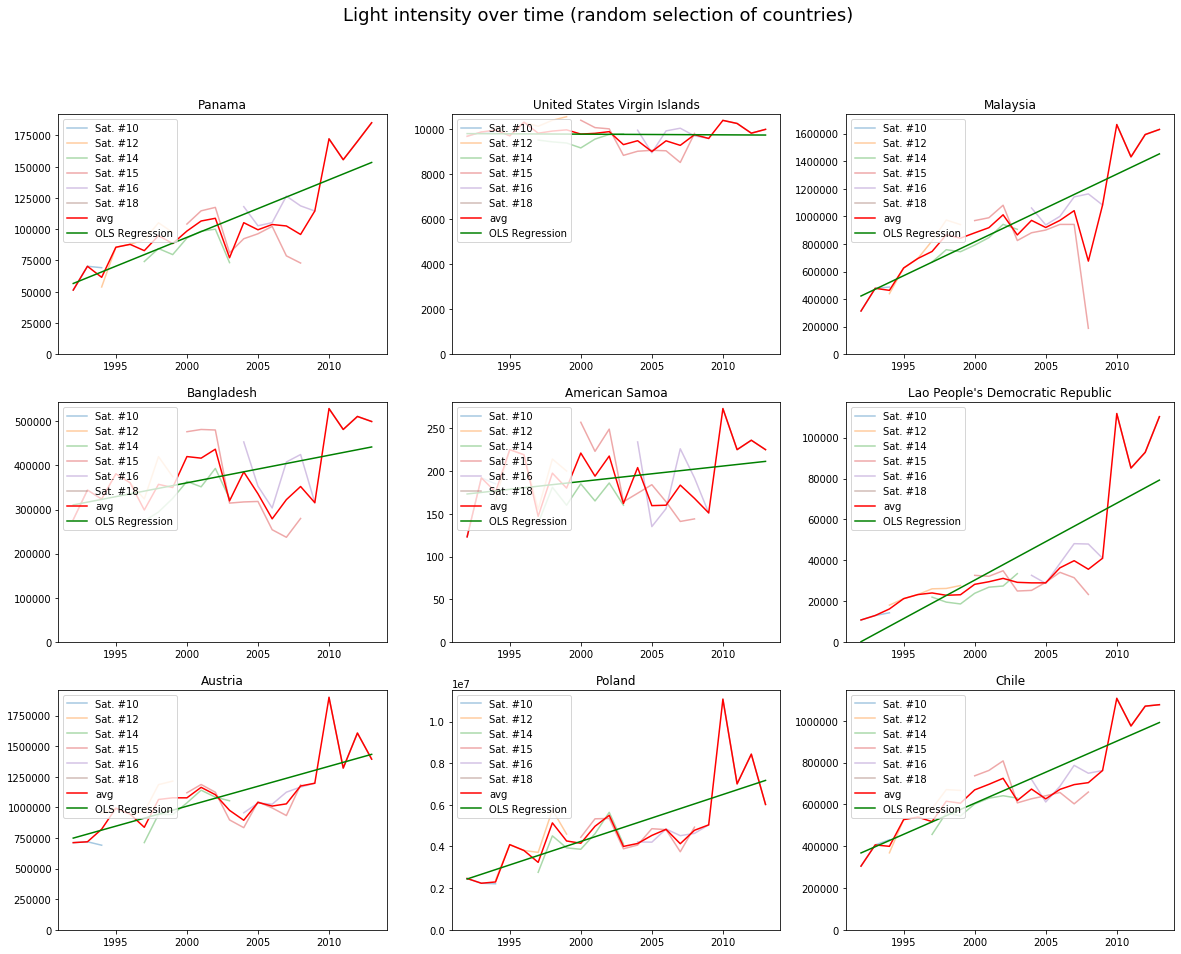

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(20,15))
fig.suptitle("Light intensity over time (random selection of countries)", fontsize=18)
sats = [10,12,14,15,16,18]

# we can choose countries to add some variation to the plot 
countries = random.choices(list(lightdict.items()), k=9)

for i,(name,cntry_tbl) in enumerate(countries):
    cntry_tbl = add_regression(cntry_tbl)
    ax = fig.add_subplot(3,3,i+1)
    plt_table(ax, cntry_tbl, code_to_country_light[name], regression=True)
plt.show()

### 1.4 Preparation of GDP data for all countries
We load the GDP data in a csv format, downloaded from the worldbank's data website

In [8]:
# load and clean data 
gdp = pd.read_csv("./data/GDP_WorldBank/gdp_data.csv", skiprows=1, header=1, index_col=1)
# gather country codes to country name dict
code_to_country_gdp = dict(gdp["Country Name"])
#gdp.set_index("Country Name", inplace=True)
years_of_relevance = list(np.arange(1992, 2014, 1).astype(str))
gdp = gdp[years_of_relevance].transpose().copy()



In [9]:
# make sure that the countries overlap
group_a = lightdict.keys()
group_b = code_to_country_gdp.keys()
countries_overlap = sorted(list(set(group_a) & set(group_b)))
gdp = gdp[countries_overlap]
lightdict = {country: lightdict[country] for country in countries_overlap}


### 1.5 Graphical exploration of the relationship between Lights and GDP

In [10]:
# use this to compare selected countries' correlation of light and GDP
def plot_light_gdp(country, light_dict, gdp_table, regression=False):
    """
    Plots the GDP value against the light intensity and adds a regression line depending on user input
    
    input: 
        country: country name as ISO3 code to select which country to display
        light_dict: the dictionary mapping from a countries ISO3 code to a dataframe with the light data over the years
        gdp_table: dataframe with gdp data
        regression: (boolean value) whether or not to add a regression line to the plot
        
    Further areas for exploration of this function would be: 
    * Add optionality to convert values to a log scale
    * Add r-squared and p-values in a box in the chart
    """
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    x = light_dict[country].mean(axis=1)
    y = gdp_table[country]
    z = list(gdp_table.index)
    ax.plot(x, y)
    for a,b,c in zip(x,y,z):
        ax.annotate(str(c), xy=(a, b), size=12)
    ax.set_title(code_to_country_light[country], size=20)
    ax.set_xlabel("light intensity")
    ax.set_ylabel("GDP")
    
    # code to add a regression line
    if regression == True:
        # check for nan values
        nans = ([x.notna()] and [y.notna()])
        nans = list(nans[0])
        x_in = x[nans]
        x_in = sm.add_constant(x_in)
        y_in = list(y[nans])
        # build linear model
        regr = sm.OLS(y_in, x_in)
        regr = regr.fit()
        x_new = np.arange(1, max(x), 1)
        preds = regr.predict(sm.add_constant(x_new))
        ax.plot(x_new, preds, label="OLS Regression", alpha=0.4, c="green")


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


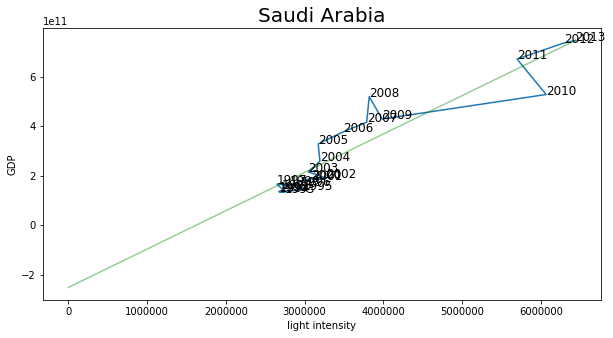

In [11]:
# we choose a random country to display
country = random.choice(list(lightdict.keys()))
plot_light_gdp(country, lightdict, gdp, regression=True)

### 1.7 Show the development of a country's lights over time

In [12]:
def yoy_development(country_code, path, save_path=None):
    """
    Displays an animation of the light activity of a country over all years of available data
    
    input: 
        country_code: the ISO3 country code of the country for which the animation should be 
            displayed. E.g. 'DEU' for Germany
        path: the file path of the directory containing the tiff files which were saved earlier. If 
            you are exploring this notebook without having created all images for the countries, then 
            set this variable to the path of the 'example_data' directory
        save_path: If you want to save the animation, the specify the file path here. If omitted the 
            animation wont be saved
    output:
        ani: the animation of the night sky. This should be displayed in the notebook
    """
    # collect images in an array
    fig_ani = plt.figure()

    ims = []
    for i in np.arange(1992, 2013, 1):
        file_path = os.path.join(path, code_to_country_light[country_code] + "_" + str(i) + ".tif")
        im = plt.imread(file_path)
        ims.append([plt.imshow(im, animated=True)])

    ani = animation.ArtistAnimation(fig_ani, ims, interval=800, blit=True, repeat_delay=2000)
    if bool(save_path):
        print("Saving file to: {}".format(save_path))
        ani.save(save_path, writer='imagemagick')
    return ani

<IPython.core.display.Javascript object>


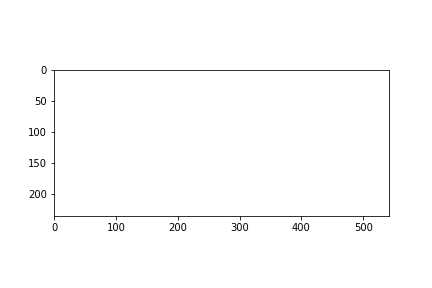

In [29]:
# a bug in the jupyter notebook code requires us to call the magic command twice
%matplotlib notebook
%matplotlib notebook
# change the folder path to your output folder path to display other countries as well
yoy_development("CHE", "./Output/example_images")

---

## 2. Making predictions based on regressions 
### 2.1 Simple OLS regression (regressing GDP on light intensity)

In [14]:
all_lights = pd.DataFrame(index=lightdict["DEU"].index, columns=lightdict.keys())
for country, data in lightdict.items():
    ### aggregation version 1: We use the average of the values if there are multiple satellite images for the same year
    all_lights[country] = data.mean(axis=1)
    
    ### aggregation version 2: 
    ### We use the newest satellite data if there are multiple satellite images for the same year
    # all_lights[country] = data.iloc[:,0]
    # for col in data.columns:
    #    all_lights[country].update(data[col][data[col].notnull()])
    
all_lights_long = all_lights.unstack() 
gdp_long = gdp.unstack()

# we set the data type of the index to the same one as in the light series, in order to 
# allow for easier merging later
gdp_long.index = gdp_long.index.set_levels([gdp_long.index.levels[0], gdp_long.index.levels[1].astype(int)]) 

all_lights_long_df = pd.DataFrame(data={"Lights": all_lights_long},)
gdp_long_df = pd.DataFrame(data={"GDP": gdp_long})
gdp_long_df.index.names = all_lights_long_df.index.names  = ["Country Code", "Year"]

master_data = gdp_long_df.join(all_lights_long_df, how="left")

In [15]:
# Build a linear model
lm_data = master_data.dropna(axis=0)
#x = lm_data.Lights
x = sm.add_constant(lm_data.Lights).astype(float)
y = lm_data.GDP.astype(float)

mod = sm.OLS(y, x)
res_v1= mod.fit()

### 2.2 Examining the results of regression

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                 1.222e+04
Date:                Mon, 15 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:38:06   Log-Likelihood:            -1.2289e+05
No. Observations:                4328   AIC:                         2.458e+05
Df Residuals:                    4326   BIC:                         2.458e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.889e+09   8.16e+09     -0.354      0.7

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


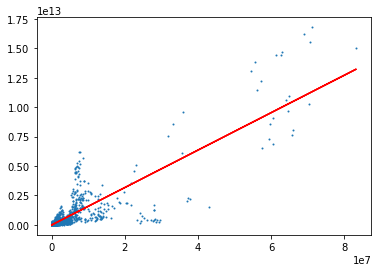

In [16]:
%matplotlib inline
# The regression is highly significant with an explained variance of 74%
print(res_v1.summary())

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x["Lights"], y, s=1)
preds = res_v1.params[0] + res_v1.params[1] * x["Lights"]
ax.plot(x["Lights"], preds, "-", c="red")


### 2.3 Use case A: Using the regression to predict the GDP of a country with unpublished figures
#### 2.3.1 North Korea
North Korea's GDP (based on a global regression)

Interesting article on the topic by the economist: https://www.economist.com/graphic-detail/2019/05/04/satellite-data-shed-new-light-on-north-koreas-opaque-economy


In [17]:
res_v1.predict(sm.add_constant(all_lights["PRK"]))

1992    2.203496e+09
1993    3.083764e+09
1994    3.155266e+09
1995    5.128719e+09
1996    4.857330e+09
1997    2.843677e+09
1998    3.742853e+09
1999    2.755888e+09
2000    3.908181e+09
2001    4.712260e+09
2002    3.367468e+09
2003    2.215492e+09
2004    3.024894e+09
2005    2.894761e+09
2006    2.517628e+09
2007    3.314080e+09
2008    1.893098e+09
2009    1.876970e+09
2010    8.196787e+09
2011    4.854152e+09
2012    6.806472e+09
2013    7.777786e+09
dtype: float64

### 2.3.2 Germany 
Testing this approach on a country with known GDP we see that the predictions can diverge quite strongly from the actual figures. For Germany (which is even in the training data) the mean absolute percentage error is 52% - a quite strong difference when it comes to GDP
(application on country with known data to demonstrate faults)

In [18]:
country = "DEU"
x_new = lm_data.loc[country, "Lights"]
prediction = res_v1.predict(sm.add_constant(x_new).astype(float))
actual = np.array(lm_data.loc[country, "GDP"])
# we use the mean absolute percentage error as a measure of accuracy
mape = np.abs((prediction - actual) / actual)
print("The mean absolute percentage error when using the regression to estimate the German GDP (in training data) is {}%".format(np.round(mape.mean(),4)*100))

The mean absolute percentage error when using the regression to estimate the German GDP (in training data) is 52.800000000000004%


### 2.4 Use Case B: Predict GDP for a subregion of a country
* GDP data is generally collected on a national level and does not allow for output to be segmented into regions. This might be interesting 
* Actual GDP for NRW in 2013 was estimated at €616 billion which was roughly $800 billion at the 2013 FX rate

In [19]:
if prepared_data== False:
    shp_file_DE = "./Data/DEU_adm/DEU_adm1.shp"
    with fiona.open(shp_file_DE) as shp:
        nrw_geo_data = list(filter(lambda f: f['properties']['NAME_1']=='Nordrhein-Westfalen', shp))[0]

    years = np.arange(1992,2014,1)
    sats = [10,12,14,15,16,18]

    nrw = pd.DataFrame(index=years, columns=sats)
    for year, sat in itertools.product(years, sats):
        nrw.loc[year, sat] = country_lights("NRW", nrw_geo_data["geometry"], year, sat)
    
    with open('./Data/NRW_light_data.pickle', 'wb') as handle:
        pickle.dump(nrw, handle, protocol=pickle.HIGHEST_PROTOCOL)
else: 
    with open('./Data/NRW_light_data.pickle', 'rb') as handle:
        nrw = pickle.load(handle)

In [20]:
# calculate GDP as a ratio of lights emitted in country
# we cant compare all the results, but actual GDP for NRW in 2013 was estimated at €616 billion which 
# was roughly $800 billion at the 2013 FX rate, so the estimates are roughly alright
nrw.mean(axis=1) / lm_data.loc[("DEU",),"Lights"] * lm_data.loc[("DEU",),"GDP"] 

1992    4.061303e+11
1993    4.243590e+11
1994    4.364965e+11
1995    4.719445e+11
1996    4.557953e+11
1997    3.962226e+11
1998    3.479825e+11
1999    3.861681e+11
2000    3.454471e+11
2001    3.391490e+11
2002    3.497003e+11
2003    4.171647e+11
2004    4.935542e+11
2005    4.582243e+11
2006    5.271547e+11
2007    6.001496e+11
2008    6.958335e+11
2009    5.833834e+11
2010    5.069764e+11
2011    6.209473e+11
2012    5.595529e+11
2013    6.164877e+11
dtype: float64

### 2.5 Use Case C: Predicting the GDP of a country for the next year based on lights only

Hypothesis: Lighting data is available before GDP figures are. Early insight into GDP figures could be advantageous in the financial markets

In [21]:
country = "URY"
x = master_data.loc[(country, np.arange(1992,2010,1)),"Lights"]
y = master_data.loc[(country , np.arange(1992,2010,1)),"GDP"]
x_c = sm.add_constant(x)
mod = sm.OLS(y,x_c)
mod = mod.fit()
x_new1 = master_data.loc[(country, np.arange(2010,2014,1)),"Lights"]
x_new1_c = sm.add_constant(x_new1)


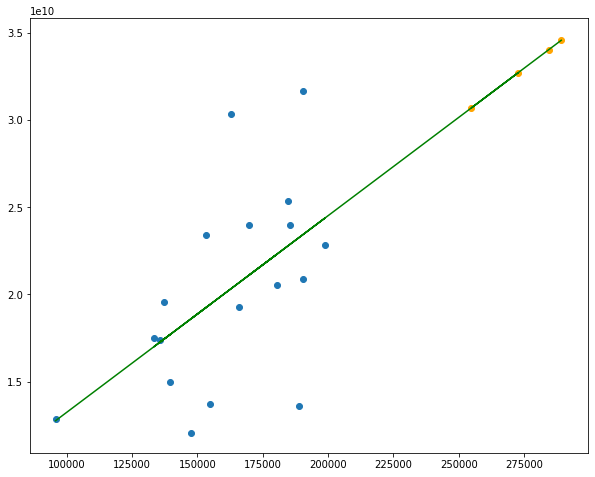

In [22]:
%matplotlib inline
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
x_new2 = master_data.loc[(country, np.arange(1992,2014,1)),"Lights"]
x_new2_c = sm.add_constant(x_new2)
ax.scatter(x,y)
ax.scatter(x_new1, mod.predict(x_new1_c), c="orange")
ax.plot(x_new2, mod.predict(x_new2_c), c="green")

In [23]:
# error as measured by the mape
originals = master_data.loc[(country, np.arange(2010,2014,1)),"GDP"]
preds = mod.predict(x_new1_c)
mape = np.abs((preds-originals)/originals).mean()
# this number seems ok-ish, but considering that a 32% divergence from the actual 
# data is acutally quite a lot, the resutls arent very useful
print("The mean absolute percentage error (MAPE) for predicting the next three years (using the respective years light data) is {}%".format(np.round(mape,4)*100))

The mean absolute percentage error (MAPE) for predicting the next three years (using the respective years light data) is 32.06%


----
## 3. (BONUS) 
### Multiple regression with urbanization data
We can add other data to try to improve our model. 

In this case we use urbanization data as we might theorize, that urbanization distorts the light data: Satellite data saturates at a max pixel value of 63, thus undervaluing the importance of cities.

### 3.1 Load and prepare the urbanization data

In [24]:
# load and clean data 
urban = pd.read_csv("./data/urbanization_WorldBank/urbanization_data.csv", skiprows=1, header=1, index_col=1)
# gather country codes to country name dict
code_to_country_urban = dict(urban["Country Name"])
years_of_relevance = list(np.arange(1992, 2014, 1).astype(str))
urban = urban[years_of_relevance].transpose().copy()
# delete countries that dont overlap with light data. 
# We already established a comparison with world bank data which we can use again.
urban = urban[countries_overlap]

In [25]:
urban_long = urban.unstack()
urban_long.index.names = master_data.index.names
urban_long.name = "Urbanization"
urban_long.index = urban_long.index.set_levels([urban_long.index.levels[0], urban_long.index.levels[1].astype(int)]) 
master_data_v2 = master_data.join(urban_long)

In [26]:
lm_data_v2 = master_data_v2.dropna(axis=0)
x = np.column_stack([lm_data_v2.Lights, lm_data_v2.Urbanization])
x = sm.add_constant(x).astype(float)
y = lm_data_v2.GDP.astype(float)

mod = sm.OLS(y, x)
res_v2 = mod.fit()

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     6166.
Date:                Mon, 15 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:38:07   Log-Likelihood:            -1.2288e+05
No. Observations:                4328   AIC:                         2.458e+05
Df Residuals:                    4325   BIC:                         2.458e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.038e+11   1.98e+10     -5.237      0.0

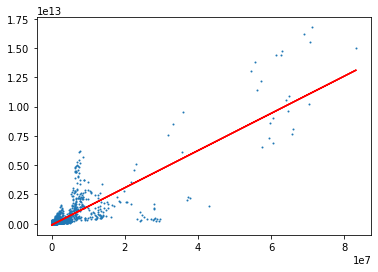

In [27]:
# The regression is highly significant with an explained variance of 74%
print(res_v2.summary())
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(lm_data_v2["Lights"], y, s=1)
preds = res_v2.params[0] + res_v1.params[1] * lm_data_v2["Lights"]
ax.plot(lm_data_v2["Lights"], preds, "-", c="red")


Error rate as measured by MAPE

In [28]:
country = "DEU"

x_new = lm_data_v2.loc[(country,),["Lights", "Urbanization"]]
x_new = sm.add_constant(x_new)
prediction = res_v2.predict(sm.add_constant(x_new))
actual = np.array(gdp[country])
# we use the mean absolute percentage error as a measure of accuracy
mape = np.abs((prediction - actual) / actual)
print("The mean absolute percentage error for the predictions of the global multiple regression on the German data (included in training data) is {}%".format(np.round(mape.mean(),4)*100))

The mean absolute percentage error for the predictions of the global multiple regression on the German data (included in training data) is 51.7%
